In [1]:
%matplotlib inline
import pymc3 as pm
from theano import shared
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 382.14it/s]


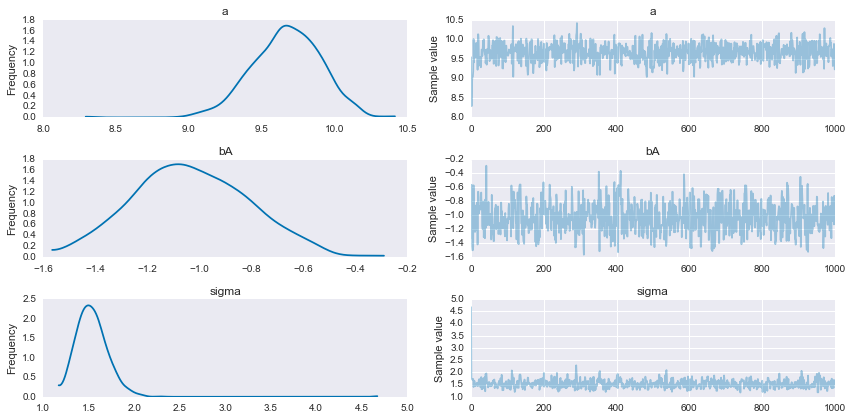

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

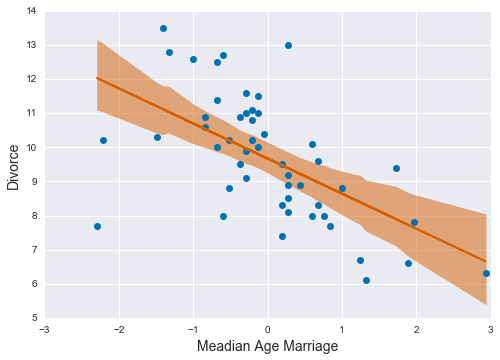

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'bo')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [6]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [7]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000)

100%|██████████| 1000/1000 [00:03<00:00, 329.61it/s]


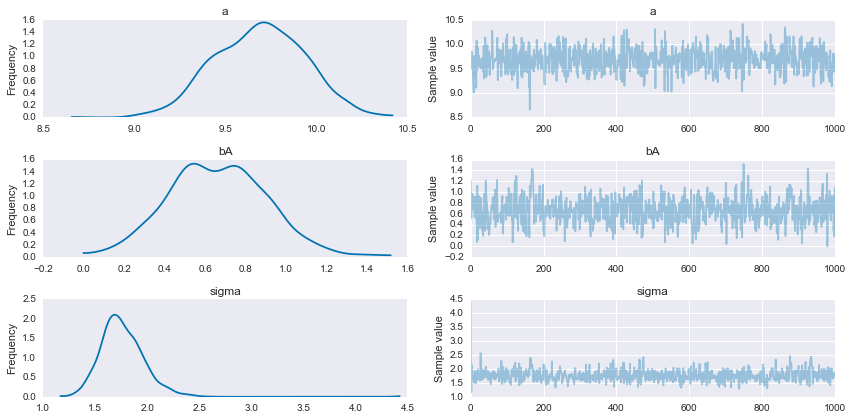

In [8]:
pm.traceplot(trace_5_2, varnames);

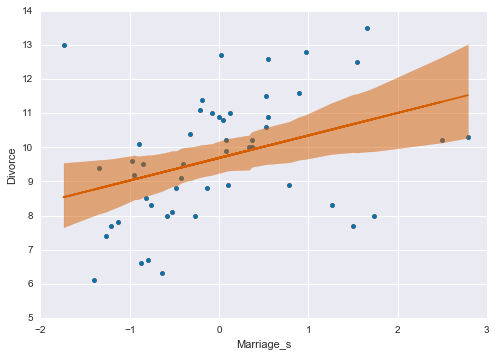

In [9]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 5.4

In [10]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000)

100%|██████████| 1000/1000 [00:04<00:00, 221.26it/s]


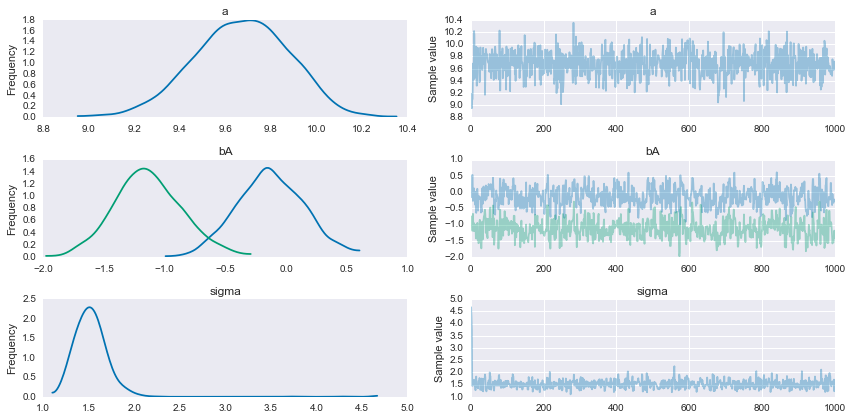

In [11]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [12]:
pm.df_summary(trace_5_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.668455,0.208319,0.007392,9.242693,10.042778
bA__0,-0.127653,0.274302,0.013089,-0.634233,0.428933
bA__1,-1.136822,0.277931,0.013613,-1.655406,-0.545334
sigma,1.535496,0.243158,0.012774,1.192894,1.839177


#### Code 5.5

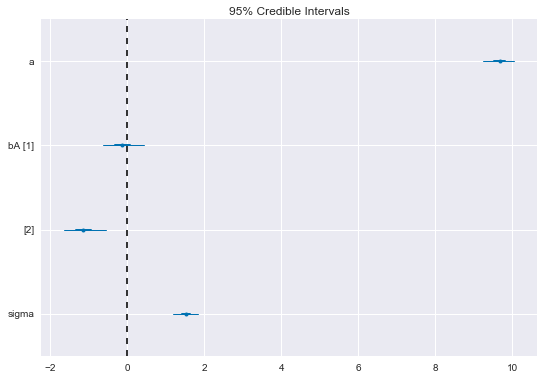

In [13]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [14]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000)

100%|██████████| 1000/1000 [00:03<00:00, 299.20it/s]


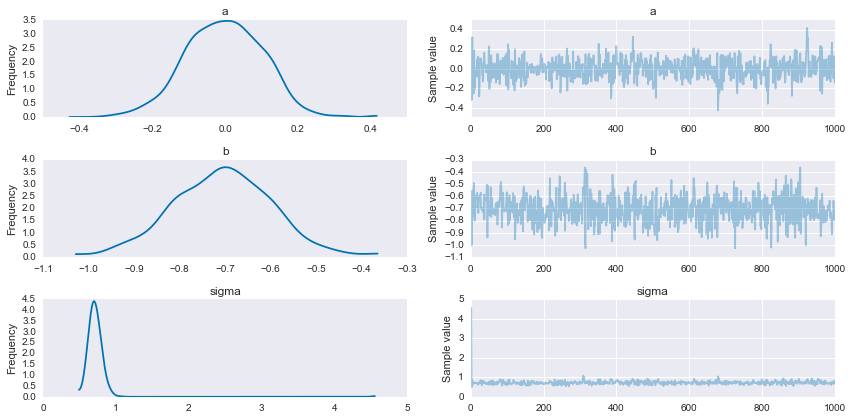

In [15]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [16]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

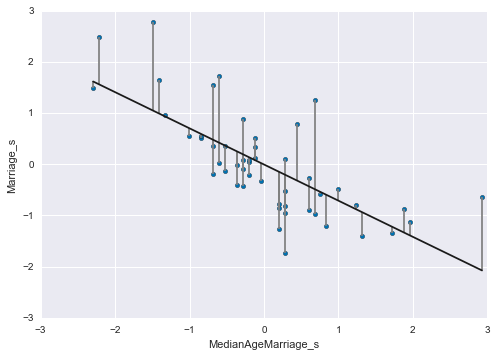

In [17]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

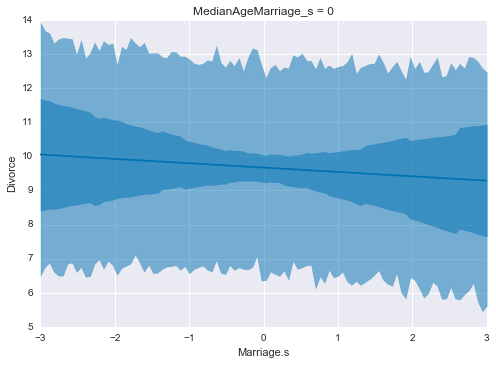

In [18]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='b', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='b', alpha=0.5)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

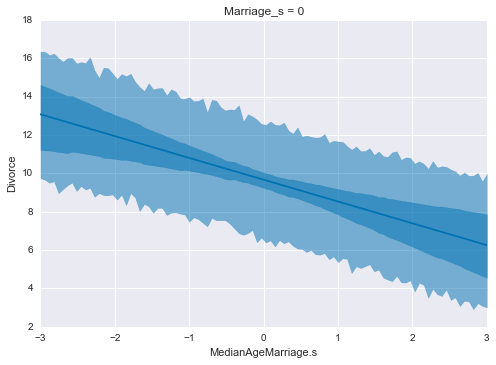

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='b', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='b', alpha=0.5)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [20]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:21<00:00, 46.75it/s]


#### Code 5.12

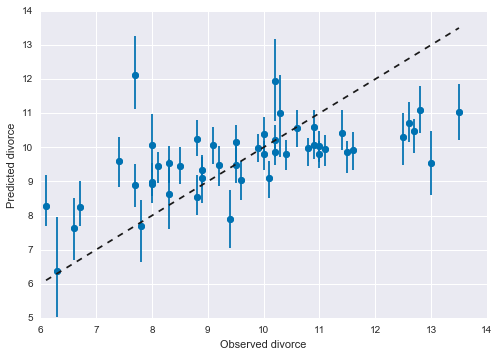

In [21]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='bo')
plt.plot(d.Divorce, divorce_pred.mean(0), 'bo')

plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

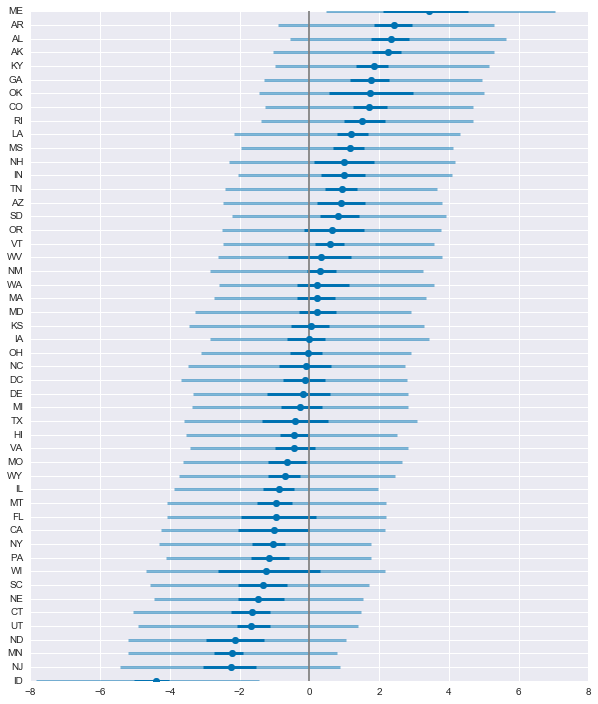

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='bo',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='bo', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

#### Code 5.x

In [23]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc4
NumPy 1.11.2
Pandas 0.19.1
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1

